This notebook serves as a testing ground to make simple visualization plots, and test sanity of various watermark detection algorithms.

In [4]:
import json
import os
import difflib
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer
from IPython.display import display, HTML
import ftfy


from llm_utilities import read_json

In [10]:
root_output_path = "../data/output/"
gumbel_data = read_json(os.path.join(root_output_path, "data_facebook-opt-125m_n100_gumbel.json"))

In [11]:
gumbel_data['configuration']

{'model_name': 'facebook/opt-125m',
 'intervals': [[0, 20, 'unwatermarked'],
  [20, 50, 'gumbel'],
  [50, 100, 'unwatermarked']],
 'prompt_tokens': 50,
 'out_tokens': 100,
 'vocab_size': 50272,
 'initial_seed': 1234,
 'max_token_input_length': 256}

In [12]:
def view_text_highlight(sample_index: int, data):
    model_name = data['configuration']['model_name']
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    raw_text = ftfy.fix_text(data['data'][sample_index]['output'])
    encoding = tokenizer(raw_text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

    def clean_tokens(tokens):
        cleaned = []
        for token in tokens:
            # Convert token to ID
            try:
                token_id = tokenizer.convert_tokens_to_ids(token)
                text = tokenizer.decode([token_id], clean_up_tokenization_spaces=True)
            except KeyError:
                text = ""  # fallback if token not in vocab

            # Optional: map common special tokens
            if text == "</s>" or text == "<s>":
                text = ""

            cleaned.append(text)
        return cleaned 

    cleaned_tokens = clean_tokens(tokens)

    prompt_tokens = data['configuration']['prompt_tokens']
    intervals = data['configuration']['intervals']
    desc = [
        ((0, prompt_tokens), "#d0e1ff", "Input")
    ]
    for start, end, type in intervals:
        if type == "unwatermarked":
            desc.append(((start + prompt_tokens, end + prompt_tokens), "#e0e0e0", "Unwatermarked"))
        else:
            desc.append(((start + prompt_tokens, end + prompt_tokens), "#ffd6d6", f"{type.capitalize()} Watermark"))

    html_tokens = []
    label_mapper = {}

    for idx, tok in enumerate(cleaned_tokens):
        label = None
        for key, (interval, color, label) in enumerate(desc):
            start, end = interval
            if start <= idx < end:
                label = str(key)
                html_tokens.append(
                    f"<span style='background:{color}; color:black;"
                    f"border-radius:3px; margin:1px;'>{tok}</span>"
                )
                break
            if label not in label_mapper:
                label_mapper[str(label)] = color
            
    legend_html = "".join(
        f"<span style='background:{c}; color:black; padding:2px 5px; border-radius:3px; margin-right:8px;'>{lbl}</span>"
        for lbl, c in label_mapper.items()
    )


    display(HTML(f"""
    <div style="background:white; padding:10px; font-family:monospace; line-height:1.6; font-size:14px;">
        <div style="margin-bottom:8px;">Legend: {legend_html}</div>
    {''.join(html_tokens)}
    </div>
    """))

sample_index = 15
view_text_highlight(sample_index, gumbel_data)


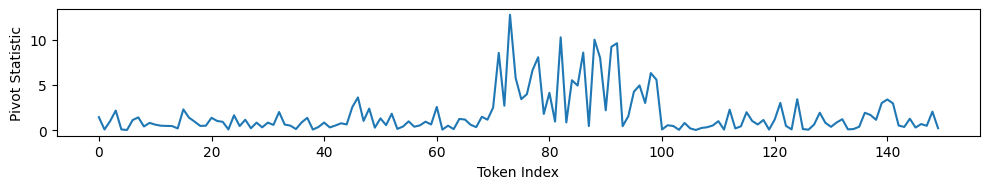

In [9]:
import numpy as np

# generate diagram
sample_index = 40
fname = "data_facebook-opt-125m_n100_gumbel.json"
dat = read_json(os.path.join("../data/output", fname))
pivots = np.concatenate([
    np.random.exponential(scale = 1, size = 50),
    dat['data'][sample_index]['pivots']
])

df = pd.DataFrame({'token_index': range(len(pivots)), 'pivot_statistic': pivots })
plt.figure(figsize=(10, 2))
sns.lineplot(data=df, x='token_index', y='pivot_statistic')
plt.xlabel('Token Index')
plt.ylabel('Pivot Statistic')
plt.tight_layout()
plt.show()

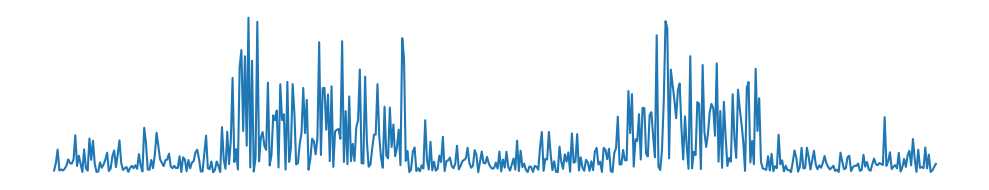

In [13]:
fname = "data_google-gemma-3-270m_n500_gumbel.json"
data = read_json(os.path.join("../data/output", fname))


# sample plot, without the margins for algorithm illustration
df = []
for sample_index, sample_data in enumerate(data["data"]):
    pivots = sample_data["pivots"]
    for token_index, pivot in enumerate(pivots):
        df.append({
            "sample_index": sample_index,
            "token_index": token_index,
            "pivot_statistic": pivot
        })

df = pd.DataFrame(df)
agg_df = df.groupby(by = ['token_index'])[['pivot_statistic']].mean().reset_index() # plot the pivot statistic

plt.figure(figsize=(10, 2))
ax = sns.lineplot(data=df.loc[df['sample_index'] == 1], # put agg_df in case of agg plot
             # agg_df,
             x='token_index', y='pivot_statistic')

ax.set(xlabel = None, ylabel = None)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Remove the top and right spines
for x in ['top', 'bottom', 'left', 'right']:
    ax.spines[x].set_visible(False)
# sns.despine()

plt.tight_layout()
plt.show()